# __FINAL PROJECT PHASE II__

# __RESEARCH QUESTION:__

What set of criteria is most important to obtain the most viewership on Netflix for movies? Are we able to accurately predict viewership according to ratings and global availability? In the past two years, have films needed to be globally available in order to reach high success?

### Data Overview & Sources:

Seven data tables were collected. The first five were taken from Netflix regarding semi-annual engagement reports starting from the first half of 2023 to the first half of 2025. Each report contains 2 tabs, Shows and Films, and their respective data (i.e. runtime, viewership, global availability). Meanwhile, the IMDb movie/shows data table displays all the movies and shows, each having their own identification tag. The IMDb rating table references these tags to provide each movie/show with their respective ratings and number of votes. The following two IMDb data tables were combined to give us an extensive IMDb table to cross reference with the Netflix reports.

Source for Netflix Engagement Report First Half 2023: https://about.netflix.com/en/news/what-we-watched-a-netflix-engagement-report

Source for Netflix Engagement Report Second Half 2023: https://about.netflix.com/en/news/what-we-watched-the-second-half-of-2023

Source for Netflix Engagement Report First Half 2024: https://about.netflix.com/en/news/what-we-watched-the-first-half-of-2024

Source for Netflix Engagement Report Second Half 2024: https://about.netflix.com/en/news/what-we-watched-the-second-half-of-2024

Source for Netflix Engagement Report First Half 2025: https://about.netflix.com/en/news/what-we-watched-the-first-half-of-2025

Source of IMDb Ratings for Movies/Shows: https://datasets.imdbws.com/title.ratings.tsv.gz

Source of IMDb Movie/Show Titles: https://datasets.imdbws.com/title.basics.tsv.gz




### Importing:

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb
from datetime import time
from sklearn.linear_model import LinearRegression, LogisticRegression
import re

In [2]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


# __Data Collection & Cleaning:__

In [3]:
#import the dataset with all ratings from IMBb. 
#note that each rating has an ID, not the show/movie title
ratings_df= pd.read_table("title.ratings.tsv")

#import the dataset with movie title given the ID
titles_df= pd.read_table("title.basics.tsv")

In [4]:
#perform an SQL join to obtain a dataframe with the rating, number of votes for that rating,
#title of the movie
merged_ratings_df= duckdb.sql("""SELECT r.tconst, r.averageRating, r.numVotes,
t.originalTitle AS Title
FROM ratings_df r, titles_df t
WHERE r.tconst=t.tconst""").df()

#drop the duplicate titles to prevent duplicate rows when merging with Netflix dataframe
merged_ratings_df = merged_ratings_df.drop_duplicates(subset=['Title'])

#merged_ratings_df.head()

In [5]:
#import 1st half of 2023 netflix data
all_jan_jun_2023= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2023Jan-Jun.xlsx",
                                  sheet_name="Engagement",
                                  skiprows=5)
all_jan_jun_2023['Time_Period']= "2023 H1"
#import 2nd half of 2023 netflix data
movies_jul_dec_2023= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2023Jul-Dec.xlsx",
                                  sheet_name="Film",
                                  skiprows=5)
movies_jul_dec_2023['Time_Period']= "2023 H2"
#import the 1st half of 2024 netflix data
movies_jan_jun_2024= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2024Jan-Jun.xlsx",
                                   sheet_name= "Film",
                                   skiprows=5)
movies_jan_jun_2024['Time_Period']= "2024 H1"
#import the 2nd half of 2024 netflix data
movies_jul_dec_2024= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2024Jul-Dec.xlsx",
                                   sheet_name= "Film",
                                   skiprows=5)
movies_jul_dec_2024['Time_Period']= "2024 H2"
#import the 1st half of 2025 netflix data
movies_jan_jun_2025= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2025Jan-Jun.xlsx",
                                   sheet_name= "Movies",
                                   skiprows=5)
movies_jan_jun_2025['Time_Period']= "2025 H1"

In [6]:
#write code to combine all these dataframes into 1 Netflix dataframe.
#be careful that some of the column names are different in different years 

netflix2023= duckdb.sql("""SELECT 
                    Title, 
                    "Available Globally?" AS Global, 
                    "Hours Viewed" AS Hours_Viewed, 
                    Runtime, Views, Time_Period
                FROM movies_jul_dec_2023 
                UNION 
                SELECT
                    Title, 
                    "Available Globally?" AS Global, 
                    "Hours Viewed" AS Hours_Viewed, 
                    NULL AS Runtime, 
                    NULL AS Views, Time_Period
                FROM all_jan_jun_2023""").df()

#print(len(all_jan_jun_2023) + len(movies_jul_dec_2023))
print(netflix2023.shape)


jan_jun_2024= duckdb.sql("""SELECT
                                Title, 
                                "Available Globally?" AS Global, 
                                "Hours Viewed" AS Hours_Viewed, 
                                Runtime, Views, Time_Period
                            FROM movies_jan_jun_2024""").df()

jul_dec_2024= duckdb.sql("""SELECT
                                Title, 
                                "Available Globally?" AS Global, 
                                "Hours Viewed" AS Hours_Viewed, 
                                Runtime, Views, Time_Period
                            FROM movies_jul_dec_2024""").df()

netflix2024= duckdb.sql("""SELECT * FROM jan_jun_2024 UNION ALL SELECT * FROM jul_dec_2024""").df()
#print(len(movies_jan_jun_2024) + len(movies_jul_dec_2024))
print(netflix2024.shape)

netflix2025= duckdb.sql("""SELECT
                                Title, 
                                "Available Globally?" AS Global, 
                                "Hours Viewed" AS Hours_Viewed, 
                                Runtime, Views, Time_Period
                            FROM movies_jan_jun_2025""").df()

#print(len(movies_jan_jun_2025))
print(netflix2025.shape)

netflix_df= duckdb.sql("""SELECT * FROM netflix2023 UNION SELECT * FROM netflix2024 UNION SELECT * 
FROM netflix2025""").df()

print(netflix_df.shape)

(27609, 6)
(18040, 6)
(8674, 6)
(54323, 6)


At this point, we have created a dataframe, netflix_df, that includes every film's viewership from the start of 2023 until the first half of 2025. 
Next, we want to match each film with its IMDb rating, if a rating exists. Unfortunately, the Netflix and IMDb sources do not have a standardized convention for their film titles. In the following several code cells, we make an effort to clean the titles as much as possible, to improve the number of matches when we merge the Netflix and ratings dataframes.

In [7]:
#Netflix films with foreign language titles have both english translation then the foreign title
#cut the title of netflix shows with foreign language titles, keeping the english title only
mod_title= netflix_df['Title']
mod_title= mod_title.str.replace(r" \/\/.*", "", regex=True)

netflix_df['Title']= mod_title

#check that the foreign language component is gone
netflix_df.head()

,Title,Global,Hours_Viewed,Runtime,Views,Time_Period
0,Havoc,Yes,154900000,1:47,86900000,2025 H1
1,The Secret Life of Pets 2,No,106800000,1:26,74500000,2025 H1
2,Honeymoon Crasher,Yes,55200000,1:35,34900000,2025 H1
3,Puss in Boots: The Last Wish,No,47600000,1:42,28000000,2025 H1
4,Leo,Yes,39700000,1:47,22300000,2025 H1


In [8]:
#look at netflix titles
#netflix_df.to_csv("netflix_titles.csv", index=False)
#merged_ratings_df.to_csv("imdb_titles.csv", index=False)

In [9]:
#look at netflix titles
netflix_df.to_csv("netflix_titles.csv", index=False)
merged_ratings_df.to_csv("imdb_titles.csv", index=False)

In [10]:
#some Netflix titles end with the year in parenthesis, which is not seen in ratings titles

year_tester= netflix_df["Title"].str.endswith(")")

#removing the last 6 characters cuts the (Year) component if it is at the end of the title
netflix_df.loc[year_tester, "Title"]= netflix_df.loc[year_tester, "Title"].str[:-6]

#check that the (Year) component is gone
#year_tester_2= netflix_df["Title"].str.endswith(")")
#netflix_df[year_tester_2].head()

In [11]:
#left join Netflix and ratings datasets
#we want to keep all the Netflix observations, or else the dataset would shrink too much
#limitation that only exact titles are matched

netflix_ratings_df= duckdb.sql("""SELECT netflix_df.Title, netflix_df.Global, 
netflix_df.Hours_Viewed, netflix_df.Runtime, netflix_df.Views, netflix_df.Time_Period, 
merged_ratings_df.averageRating, merged_ratings_df.numVotes
FROM netflix_df
INNER JOIN merged_ratings_df
ON netflix_df.Title= merged_ratings_df.Title""").df()

#making time column to have type time, then adjusting runtime to be in minutes
netflix_ratings_df["Runtime"] = pd.to_datetime(netflix_ratings_df['Runtime'], format='%H:%M')
netflix_ratings_df["Runtime"] = netflix_ratings_df["Runtime"].dt.hour*60 + netflix_ratings_df["Runtime"].dt.minute

#Finding average runtime and plugging it in to the missing values of runtime without skewing the data 
#to complete the dataframe enabling us to make future analysis
avgRuntime = np.round(np.mean(netflix_ratings_df["Runtime"]))
isEmptyRuntime = netflix_ratings_df["Runtime"].isna()
netflix_ratings_df.loc[isEmptyRuntime, "Runtime"] = avgRuntime

#Calculating views for empty values for Views column using runtime and hours viewed
isEmptyViews = netflix_ratings_df["Views"].isna()
netflix_ratings_df.loc[isEmptyViews, "Views"] = netflix_ratings_df["Hours_Viewed"]/np.round(avgRuntime/60)

#create new columns to use in future binary analysis on global avaiability 
netflix_ratings_df["Is_Global"] = netflix_ratings_df["Global"].map({'Yes': 1, 'No': 0})

#create new column that determines success based on being above and below average views
netflix_ratings_df["Successful"] = netflix_ratings_df["Views"] > np.mean(netflix_ratings_df["Views"])
netflix_ratings_df["Successful"] = netflix_ratings_df["Successful"].map({True: int(1), False: int(0)})

print(netflix_ratings_df.shape) #yes, the size is the same as the netflix only dataframe

#save this as an intermediate dataset in our final submission
#used below code to troubleshoot the merge being the wrong size
netflix_ratings_df.to_csv('my_dataframe.csv', index=False) 

(26413, 10)


# __Data Description:__


Our Netflix dataframe was created by joining multiple Netflix engagement reports from different periods and merged with the IMDb ratings dataset to observe if any factors had the most influence on viewership for Netflix films and predict viewership for films outside of the dataset according to observed criteria. All datasets used during this phase and their creation were funded by either Netflix or IMDb. 

The dataset consists of 48,231 Netflix films watched from January 2023 to June 2025, along with their respective attributes in terms of global availability, release date, hours viewed, runtime, views, average IMDb rating, number of votes, and genres. 

Our original plan was to create a dataset containing both Netflix films and shows but upon merging with the IMDb dataset, we discovered that many shows were missing rating information and so we decided to focus solely on films. This meant reducing our dataset by a couple thousand rows but given that we are still able to work with around 48,000 instances of films, we should have sufficient data for performing exploratory analysis. We decided to retain the majority of the attributes found in both the Netflix and IMDb datasets since our research aims to identify which factors most strongly influence viewership. Removing such attributes could limit the scope of our findings later on. 

Much of the data cleaning that was performed using SQL. Our first task involved merging the IMDb datasets together, as title.ratings.tsv only contains ratings corresponding to an ID and not a film title while title.basics.tsv includes the corresponding film title along with their respective IDs. By performing a SQL join on these two datasets, we obtained a single dataframe containing both film titles and their ratings. 

The second task was to combine all of Netflix’s semi-annual engagement datasets into a master dataset. Using the UNION ALL operator in SQL, we were able to successfully retain all instances from all four datasets. During this process, we also noticed that some Netflix films contained titles in their original languages which would be a problem when merging with the IMDb dataset that only has titles in English. To ensure consistent title matching, we cleaned up the film titles by removing the extra info that followed // by simply replacing a part of the title string with an empty string. 

Once that was done, we performed a left join between our Netflix and IMDb datasets using the shared column Title. This join type allowed us to keep all instances of the Netflix dataset, even those without corresponding IMDb data, so our dataset wouldn’t be too limited to only titles that are matched. Additionally, we created two dummy variables, Is_Global and Successful, to support our exploratory analysis. The Is_Global variable was encoded as 1 for films globally available and 0 for unavailable. The boolean column, Successful, that marked whether a film had more than 50 million views was created and then converted into a binary variable with 1 being successful and 0 for not successful. 

All raw source data can be found on the Github folder which can also be accessed here. 
https://github.com/xuanlianliu/Data_Science_Project

# __Data Limitations:__


There were several limitations we discovered in our dataset. Upon cleaning, we noticed that many of the films were missing release dates, making us reconsider whether this variable should be used to analyze and predict viewership. Our dataset also only covers a 2.5-year period worth of Netflix data spanning from January 2023 to June 2025. This short timeframe might make it hard for us to generalize our findings to other years and their films and may affect the accuracy of our predictive models. We also experienced limitations from the ratings dataset. Most importantly, not every Netflix title matches with an IMDb rating, so there are many missing ratings. This harms our predictions of viewership based on ratings because many films are missing from the analysis. We also observed variation in the number of votes that determined each film’s IMDb rating. Films with a smaller number of votes could skew the rating, which could ultimately affect our analysis of how ratings correlate with viewership. 

# __Exploratory Data Analysis:__


### Movie Viewership based on Ratings and Global Availability:

Linear Regression (x - ratings, y - viewership), Avg Views on each rating as bar graph

To help gauge whether or not there is a relationship between Views and Ratings and the relationship between Views and Global Availability, we need a series of graphs.

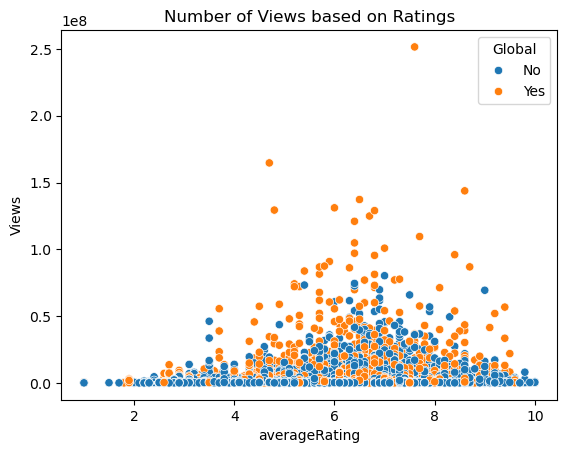

In [12]:
#Scatterplot analysis on the number of views for a movie based on the ratings and global availability
plot = sns.scatterplot(netflix_ratings_df, 
             x='averageRating', y='Views', marker='o', hue="Global")
plt.title("Number of Views based on Ratings");

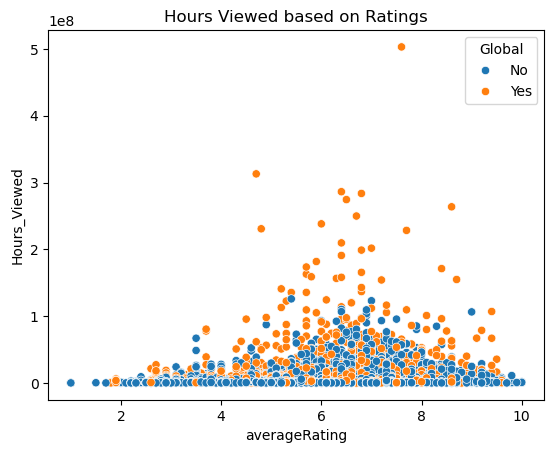

In [13]:
#Scatterplot analysis on the hours viewed for a movie based on the ratings and global availability
plot = sns.scatterplot(netflix_ratings_df, 
             x='averageRating', y='Hours_Viewed', marker='o', hue="Global")
plt.title("Hours Viewed based on Ratings");

The model's slope is: 107010.78
The model's intercept is: 1141925.31


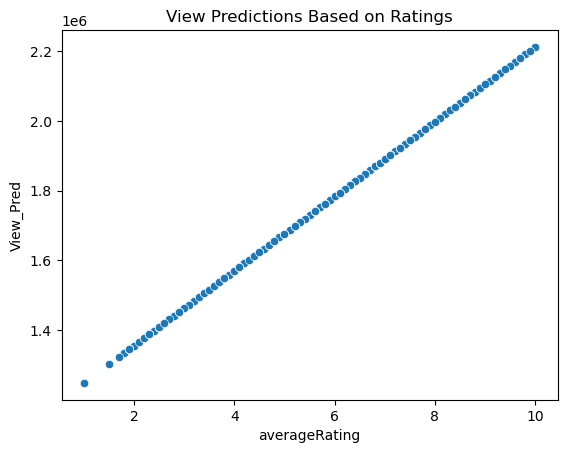

In [14]:
#Linear Regression analysis on ratings to predict view counts
no_nan_df = netflix_ratings_df.copy().dropna()
x = no_nan_df[['averageRating']].values
y = no_nan_df[['Views']].values

ratings_model = LinearRegression().fit(x,y)
print("The model's slope is: " + str(round(float(ratings_model.coef_[0][0]),2)))
print("The model's intercept is: " + str(round(float(ratings_model.intercept_[0]),2)))

no_nan_df["View_Pred"] = ratings_model.predict(x)
plot2 = sns.scatterplot(no_nan_df, 
             x='averageRating', y='View_Pred')
plt.title("View Predictions Based on Ratings");


### Movie Viewership over Time:

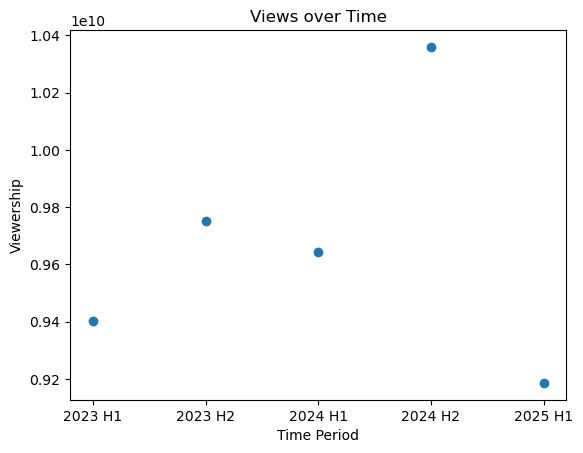

In [15]:
#find the total views per each time period
netflix_summarized= duckdb.sql("""SELECT Time_Period,
SUM(Views) as Total_Views,
FROM netflix_ratings_df
WHERE Views IS NOT NULL
GROUP BY Time_Period
ORDER BY Time_Period ASC""").df()

#check the new dataframe
#print(netflix_summarized) #2021 H1 is gone. I think it has needs more cleaning above

#graph the views over time with a scatterplot
viewership_plot= plt.plot(netflix_summarized['Time_Period'], netflix_summarized['Total_Views'], 'o')
plt.title("Views over Time")
plt.xlabel('Time Period')
plt.ylabel('Viewership')
plt.show()

In [26]:
#correlation matrix for netflix attributes
corr_df = netflix_ratings_df[['Views', 'Hours_Viewed', 'Runtime', 'Is_Global', 'averageRating', 'numVotes']].corr()
print(corr_df)

                  Views  Hours_Viewed   Runtime  Is_Global  averageRating  \
Views          1.000000      0.986008  0.017555   0.158632       0.022267   
Hours_Viewed   0.986008      1.000000  0.072498   0.151794       0.028462   
Runtime        0.017555      0.072498  1.000000  -0.102393       0.134975   
Is_Global      0.158632      0.151794 -0.102393   1.000000      -0.025226   
averageRating  0.022267      0.028462  0.134975  -0.025226       1.000000   
numVotes       0.068435      0.077669  0.160602  -0.094217       0.148132   

               numVotes  
Views          0.068435  
Hours_Viewed   0.077669  
Runtime        0.160602  
Is_Global     -0.094217  
averageRating  0.148132  
numVotes       1.000000  


In [17]:
#fitting a logistic regression model that predicts if movie is successful given average ratings
x = netflix_ratings_df['averageRating'].values.reshape(-1, 1)
y = netflix_ratings_df['Successful']
model = LogisticRegression().fit(x,y)

print(model.coef_[0][0])
print(model.intercept_[0])

0.05396584122676311
-1.7127462662873378


<Axes: xlabel='averageRating', ylabel='successful_pred'>

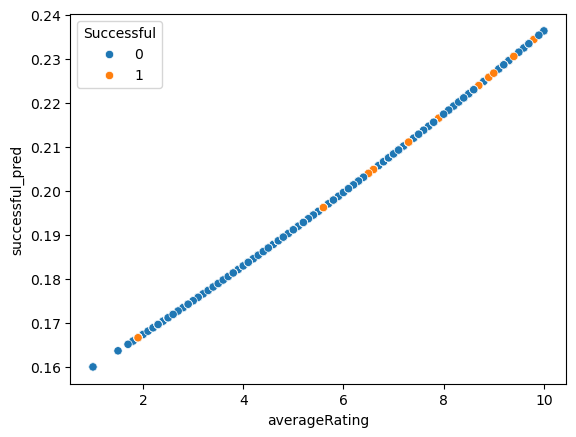

In [25]:
#using model's predict_proba to find probability of a movie being successful
netflix_ratings_df['successful_pred'] = model.predict_proba(netflix_ratings_df[['averageRating']].values)[:, 1]
sns.scatterplot(x = netflix_ratings_df['averageRating'], y = netflix_ratings_df['successful_pred'], hue = netflix_ratings_df['Successful'])                                                           

In [27]:
sns.scatterplot(netflix_ratings_df, x = 'averageRating', y= 'numVotes)

SyntaxError: unterminated string literal (detected at line 1) (2389858123.py, line 1)

In [ ]:
#Top 100 films

netflix_top_100= duckdb.sql("""SELECT *
FROM netflix_ratings_df
WHERE Views IS NOT NULL
ORDER BY Views DESC
LIMIT 100""").df()

#graph the top 100 films
#top_100_plot= sns.scatterplot(netflix_top_100, x= "Ratings", y= "Views", market= "o", hue="Global")
#top_100_plot= plt.plot(netflix_top_100['Time_Period'], netflix_top_100['Views'], 'o')
#plt.title("Top 100 Films")
#plt.show()

g=sns.FacetGrid(netflix_top_100, col="Time_Period")
g.map_dataframe(sns.histplot, x="Views")
plt.show()

In [ ]:
#Top 100 viewed films by global availability
yes_count = (netflix_top_100["Global"]=="Yes").sum()
no_count  = (netflix_top_100["Global"]=="No").sum()

y = np.array([yes_count, no_count])
mylabels = ["Global", "Not Global"]

plt.pie(y, labels = mylabels)
plt.title("Global Availability of Top 100 Most-Watched Films")
plt.show() 

# __Questions for Reviewers:__


How can we improve the merge of the netflix films and the IMDb ratings? Currently, we are joining by title after removing the foreign language part of the netflix titles. There is certainly variation in the way that films are listed across the two sources, which causes us to have more missing ratings than what exists.

What are some other types of graphs we can make to explore our research question?

Is the linear regression between ratings and viewership appropriate? One consideration is that someone would only rate the film after they watch it. Therefore, is it possible for ratings be on the x-axis while viewership is on the y-axis?